In [ ]:
!pip install -q gensim nltk spacy sklearn pandas scipy
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
2023-07-12 13:19:19.486976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
''' Dataset for Sematic Textual Similarity task '''
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn
from multiprocessing import Pool

In [ ]:
nlp = spacy.load('en_core_web_sm')
with open(r'/content/drive/MyDrive/Colab Notebooks/Spearman/LP50.txt', 'r') as f:
    documents = [line.strip() for line in f]

gt_scores_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Spearman/LP50_averageScores.csv')
gt_scores = gt_scores_df['average'].values

''' Function to calculate similarities '''
def calc_similarity_scores_ordered(documents, metric_function):
    scores = []
    for index1, doc1 in enumerate(documents):
        for index2, doc2 in enumerate(documents):
            if index1 < index2:
                score = metric_function(doc1, doc2)
                scores.append(score)
    return scores

In [ ]:
with open(r"/content/drive/MyDrive/Colab Notebooks/Spearman/corpus.txt", "r", encoding='utf-8') as file:
    corpus = [line.strip() for line in file]
print(len(corpus))

200


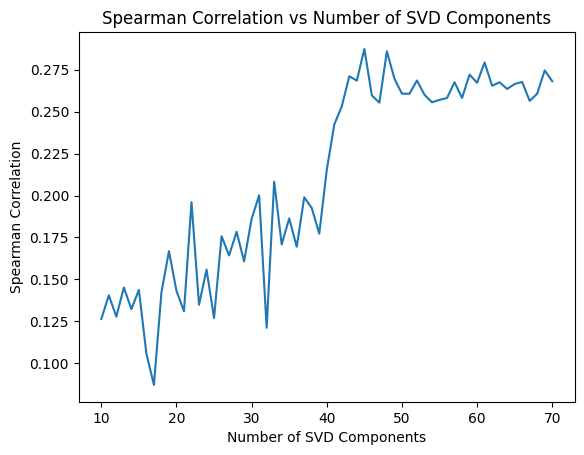

The highest Spearman Correlation of 0.2873476511301126 is achieved with 45 SVD components.


In [ ]:
import matplotlib.pyplot as plt

def lsa_similarity_svd_components(documents, n_components: int):
    vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
    tfidf = vectorizer.fit_transform(documents)
    svd = TruncatedSVD(n_components)
    lsa = make_pipeline(svd, Normalizer(copy=False, norm='l2'))
    tfidf_lsa = lsa.fit_transform(tfidf)

    scores = []
    for index1 in range(tfidf_lsa.shape[0]):
        for index2 in range(index1 + 1, tfidf_lsa.shape[0]):
            similarity = cosine_similarity(tfidf_lsa[index1].reshape(1, -1), tfidf_lsa[index2].reshape(1, -1))
            scores.append(abs(similarity[0][0]))
    return scores

n_components_range = range(10, 71)
spearman_correlations = []

for n_components in n_components_range:
    lsa_scores = lsa_similarity_svd_components(documents, n_components)
    spearman_corr = spearmanr(lsa_scores, gt_scores)[0]
    spearman_correlations.append(spearman_corr)

max_corr = max(spearman_correlations)
max_corr_index = spearman_correlations.index(max_corr)
optimal_n_components = n_components_range[max_corr_index]

plt.plot(n_components_range, spearman_correlations)
plt.xlabel('Number of SVD Components')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation vs Number of SVD Components')
plt.show()

print(f"The highest Spearman Correlation of {max_corr} is achieved with {optimal_n_components} SVD components.")

In [ ]:
from functools import lru_cache
def convert_tag(tag):
    tag_dict = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        return None

@lru_cache(maxsize=None)
def doc_to_synsets(doc):
    tokens = nltk.word_tokenize(doc)
    pos = nltk.pos_tag(tokens)
    tags = [tag[1] for tag in pos]
    wntag = [convert_tag(tag) for tag in tags]
    ans = list(zip(tokens,wntag))
    sets = [wn.synsets(x,y) for x,y in ans]
    final = [val[0] for val in sets if len(val) > 0]
    return final

@lru_cache(maxsize=None)
def path_similarity_score(i1, i2):
    return i1.path_similarity(i2)

def similarity_score(s1, s2):
    scores = [
        max([path_similarity_score(i1, i2) for i2 in s2 if path_similarity_score(i1, i2) is not None])
        for i1 in s1
    ]
    scores = [score for score in scores if score is not None]
    return sum(scores) / len(scores) if scores else 0

def document_path_similarity(doc1, doc2):
    synsets1 = doc_to_synsets(doc1)
    synsets2 = doc_to_synsets(doc2)
    return (similarity_score(synsets1, synsets2) + similarity_score(synsets2, synsets1)) / 2


document_path_scores = calc_similarity_scores_ordered(documents, document_path_similarity)

print('Spearman between Synset and groundtruth: ',spearmanr(document_path_scores, gt_scores)[0])

Spearman between Synset and groundtruth:  0.11664965295790712


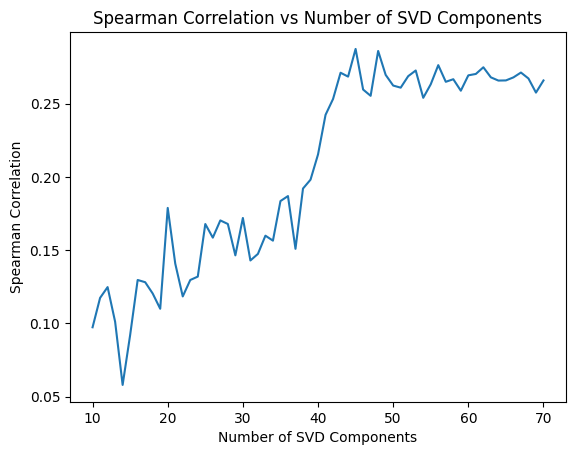

In [ ]:
import matplotlib.pyplot as plt

def lsa_similarity_svd_components(documents, n_components: int):
    vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
    tfidf = vectorizer.fit_transform(documents)
    svd = TruncatedSVD(n_components)
    lsa = make_pipeline(svd, Normalizer(copy=False, norm='l2'))
    tfidf_lsa = lsa.fit_transform(tfidf)

    scores = []
    for index1 in range(tfidf_lsa.shape[0]):
        for index2 in range(index1 + 1, tfidf_lsa.shape[0]):
            similarity = cosine_similarity(tfidf_lsa[index1].reshape(1, -1), tfidf_lsa[index2].reshape(1, -1))
            scores.append(abs(similarity[0][0]))
    return scores

n_components_range = range(10, 71)
spearman_correlations = []

for n_components in n_components_range:
    lsa_scores = lsa_similarity_svd_components(documents, n_components)
    spearman_corr = spearmanr(lsa_scores, gt_scores)[0]
    spearman_correlations.append(spearman_corr)

plt.plot(n_components_range, spearman_correlations)
plt.xlabel('Number of SVD Components')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation vs Number of SVD Components')
plt.show()

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(r'/content/drive/MyDrive/Colab Notebooks/Spearman/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def word2vec_tf_similarity(text1: str, text2: str) -> float:

    vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
    tfidf = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_dict = dict(zip(feature_names, vectorizer.idf_))

    text1 = nlp(text1.lower())
    text2 = nlp(text2.lower())

    text1 = [token.lemma_ for token in text1 if not token.is_stop and not token.is_punct]
    text2 = [token.lemma_ for token in text2 if not token.is_stop and not token.is_punct]

    vector1 = np.mean([word2vec[word] * tfidf_dict.get(word, 1) for word in text1 if word in word2vec.key_to_index], axis=0)
    vector2 = np.mean([word2vec[word] * tfidf_dict.get(word, 1) for word in text2 if word in word2vec.key_to_index], axis=0)

    if vector1 is not None and vector2 is not None:
        cosine_similarity_value = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
        return float(cosine_similarity_value)
    else:
        return 0.0

In [89]:
def word2vec_similarity(text1 :str, text2: str) -> float:
    text1 = nlp(text1.lower())
    text2 = nlp(text2.lower())
    text1 = [token.lemma_ for token in text1 if not token.is_stop and not token.is_punct]
    text2 = [token.lemma_ for token in text2 if not token.is_stop and not token.is_punct]
    vector1 = np.mean([word2vec[word] for word in text1 if word in word2vec.key_to_index], axis=0)
    vector2 = np.mean([word2vec[word] for word in text2 if word in word2vec.key_to_index], axis=0)
    cosine_similarity_value = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    return float(cosine_similarity_value)

In [ ]:
word2vec_scores = calc_similarity_scores_ordered(documents, word2vec_tf_similarity)

In [90]:
w2v_score = calc_similarity_scores_ordered(documents, word2vec_similarity)

In [92]:
print('Spearman between Word2vec and groundtruth: ',spearmanr(word2vec_scores, gt_scores)[0])
print('Spearman between Word2vec and groundtruth: ',spearmanr(w2v_score, gt_scores)[0])

Spearman between Word2vec and groundtruth:  0.5636326929902126
Spearman between Word2vec and groundtruth:  0.5639404823264279


In [93]:
from sklearn.feature_extraction.text import CountVectorizer

def ngram_similarity(text1: str, text2: str, n_gram=2) -> float:
    # Tiền xử lý văn bản
    text1 = nlp(text1.lower())
    text2 = nlp(text2.lower())
    text1 = ' '.join([token.lemma_ for token in text1 if not token.is_stop and not token.is_punct])
    text2 = ' '.join([token.lemma_ for token in text2 if not token.is_stop and not token.is_punct])

    vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram))
    corpus = [text1, text2]
    vectorized_corpus = vectorizer.fit_transform(corpus)
    cosine_similarity_value = cosine_similarity(vectorized_corpus)[0, 1]
    return float(cosine_similarity_value)

ngram_score = calc_similarity_scores_ordered(documents, ngram_similarity)

In [94]:
print('Spearman between n-gram and groundtruth: ',spearmanr(word2vec_scores, ngram_score)[0])

Spearman between n-gram and groundtruth:  0.0984410190549771


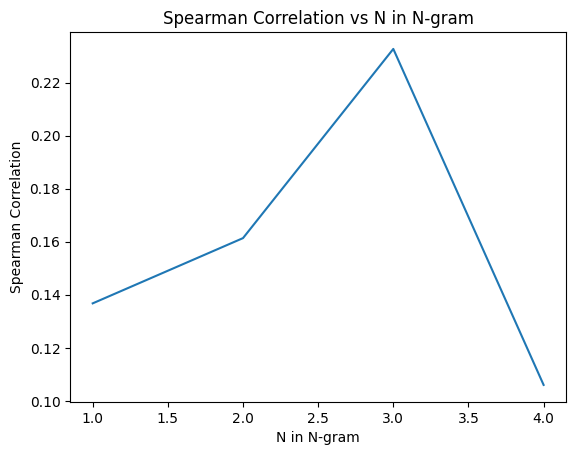

In [102]:
import matplotlib.pyplot as plt

def ngram_similarity(text1: str, text2: str, n_gram=2) -> float:
    vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram))
    corpus = [text1, text2]
    vectorized_corpus = vectorizer.fit_transform(corpus)
    cosine_similarity_value = cosine_similarity(vectorized_corpus)[0, 1]
    return float(cosine_similarity_value)

n_values = list(range(1, 21))
spearman_values = []

for n in n_values:
    ngram_scores = calc_similarity_scores_ordered(documents, lambda x, y: ngram_similarity(x, y, n_gram=n))
    spearman_corr = spearmanr(ngram_scores, gt_scores)[0]
    spearman_values.append(spearman_corr)

plt.plot(n_values, spearman_values)
plt.xlabel('N in N-gram')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation vs N in N-gram')
plt.show()


In [103]:
# Tìm giá trị tốt nhất
best_spearman_value = max(spearman_values)
best_n_value = n_values[spearman_values.index(best_spearman_value)]

print(f"Best Spearman Correlation: {best_spearman_value}")
print(f"Best N value for N-gram: {best_n_value}")

Best Spearman Correlation: 0.23271778522308356
Best N value for N-gram: 3
